<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/Image_Classification/image_classification_dataset_90_animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

import tensorflow as tf
from tensorflow import keras
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers

mixed_precision.set_global_policy('mixed_float16')

print(tf.__version__)

2.17.0


Loading Dataset:

In [5]:
path = "/content/drive/MyDrive/Colab Notebooks/archive_90_animals.zip"

In [6]:
zip_path = path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

Verify the extracted files:

In [7]:
!ls /content/animals/animals/

antelope     cockroach	elephant     hippopotamus  lobster    parrot	      seahorse	turtle
badger	     cow	flamingo     hornbill	   mosquito   pelecaniformes  seal	whale
bat	     coyote	fly	     horse	   moth       penguin	      shark	wolf
bear	     crab	fox	     hummingbird   mouse      pig	      sheep	wombat
bee	     crow	goat	     hyena	   octopus    pigeon	      snake	woodpecker
beetle	     deer	goldfish     jellyfish	   okapi      porcupine       sparrow	zebra
bison	     dog	goose	     kangaroo	   orangutan  possum	      squid
boar	     dolphin	gorilla      koala	   otter      raccoon	      squirrel
butterfly    donkey	grasshopper  ladybugs	   owl	      rat	      starfish
cat	     dragonfly	hamster      leopard	   ox	      reindeer	      swan
caterpillar  duck	hare	     lion	   oyster     rhinoceros      tiger
chimpanzee   eagle	hedgehog     lizard	   panda      sandpiper       turkey


In [8]:
path = '/content/animals/animals/'

In [9]:
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

Split the Dataset into Train & Test

In [10]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                            imgpath    labels
0     /content/animals/animals/tiger/3f090f0f2a.jpg     tiger
1    /content/animals/animals/lizard/89fcf3e801.jpg    lizard
2  /content/animals/animals/kangaroo/590af7099b.jpg  kangaroo
3  /content/animals/animals/ladybugs/5b8db3578c.jpg  ladybugs
4       /content/animals/animals/dog/89af0e8454.jpg       dog
(3779, 3)
--------Validation----------
                                         imgpath labels
0   /content/animals/animals/duck/24f7e684eb.jpg   duck
1  /content/animals/animals/tiger/333dd0655b.jpg  tiger
2    /content/animals/animals/owl/002bb8e03b.jpg    owl
3    /content/animals/animals/bee/5f4eacc507.jpg    bee
4  /content/animals/animals/otter/7ee33914bc.jpg  otter
(1134, 3)
----------Test--------------
                                             imgpath       labels
0  /content/animals/animals/grasshopper/1fbdcee16...  grasshopper
1      /content/animals/animals/mouse/719c8d79b6.jpg 

Show sample from data

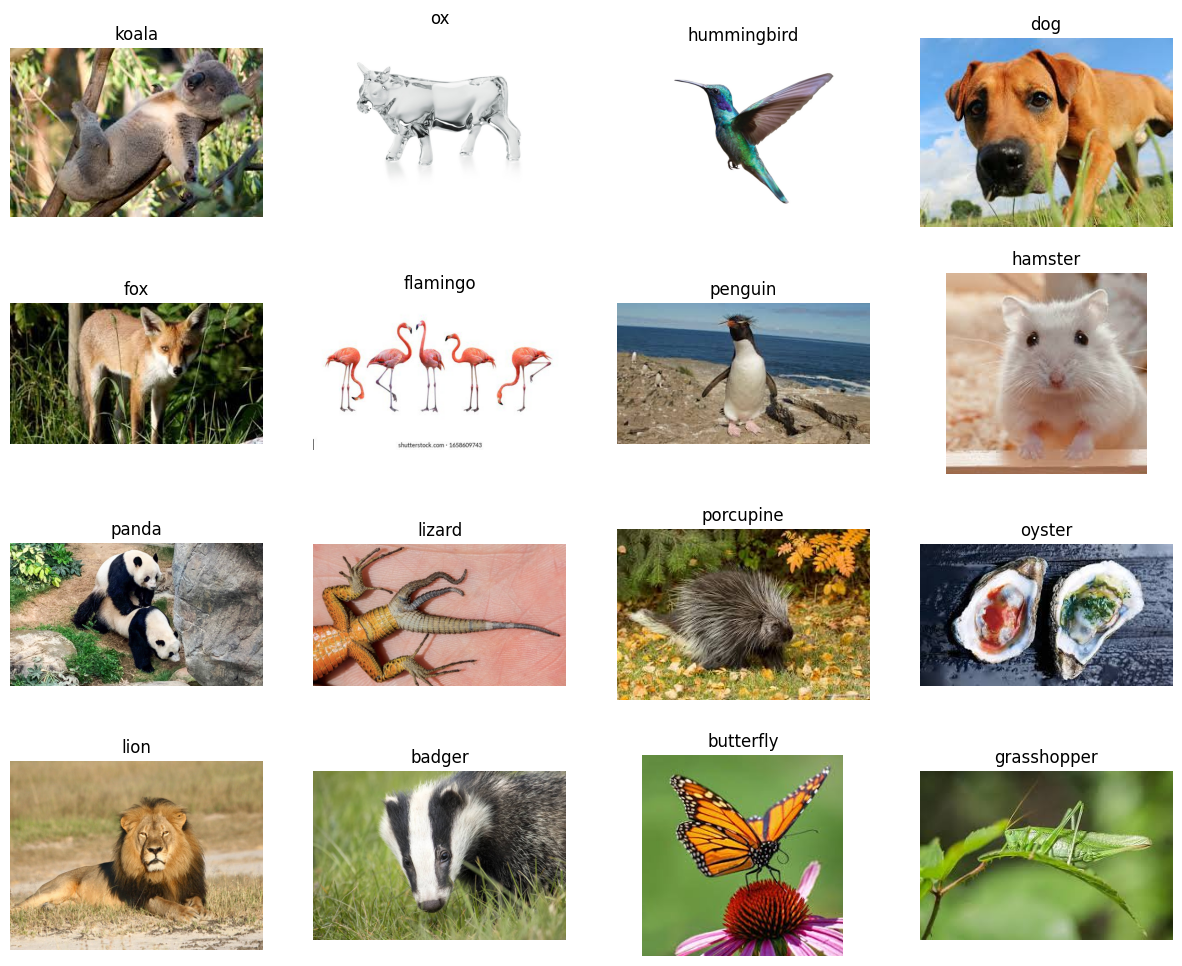

In [11]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

Creating Dataloaders:

In [12]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.
CPU times: user 38.1 ms, sys: 12.9 ms, total: 51 ms
Wall time: 50.8 ms


Model Structure

In [13]:
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for layer in pretrained_model.layers:
    layer.trainable = False

# Unfreezing the las 50 layers of a pretrained neural network
for layer in pretrained_model.layers[-50:]:
    layer.trainable = True

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
num_classes = len(set(train_images.classes))

In [16]:
pretrained_model.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 4,727,220 (18.03 MB)

 Non-trainable params: 6,056,315 (23.10 MB)

In [17]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.10),
  layers.RandomZoom(0.10),
  layers.RandomContrast(0.10),
  layers.RandomBrightness(0.2),
  layers.RandomTranslation(0.2, 0.2),
], name='AugmentationLayer')

In [18]:
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

In [19]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 90)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,201,161 (42.73 MB)

 Trainable params: 5,144,334 (19.62 MB)

 Non-trainable params: 6,056,827 (23.10 MB)

Training : Transfer Learning

In [21]:
print(f"Number of training samples: {train_images.samples}")
print(f"Number of validation samples: {val_images.samples}")

Number of training samples: 3779
Number of validation samples: 1134


In [22]:
history = model.fit(
    train_images,
    steps_per_epoch=train_images.samples // train_images.batch_size,
    validation_data=val_images,
    validation_steps=val_images.samples // val_images.batch_size,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor="val_loss", # watch the val loss metric
                      patience=5,
                      restore_best_weights=True), # if val loss decreases for 20 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min')
    ]
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 182ms/step - accuracy: 0.0321 - loss: 5.1546 - val_accuracy: 0.3956 - val_loss: 2.6246 - learning_rate: 1.0000e-04
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2000 - loss: 3.5571 - val_accuracy: 0.4444 - val_loss: 2.4908 - learning_rate: 1.0000e-04
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.2652 - loss: 3.2574 - val_accuracy: 0.6444 - val_loss: 1.5723 - learning_rate: 1.0000e-04
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2000 - loss: 2.8033 - val_accuracy: 0.7778 - val_loss: 1.1821 - learning_rate: 1.0000e-04
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.4705 - loss: 2.2835 - val_accuracy: 0.7404 - val_loss: 1.1761 - learning_rate: 1.0000e-04
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5714 - loss: 1.7245 - val_accuracy: 0.7778 - val_loss: 0.9837 - learning_rate: 1.0000e-04
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step 

Display model performance

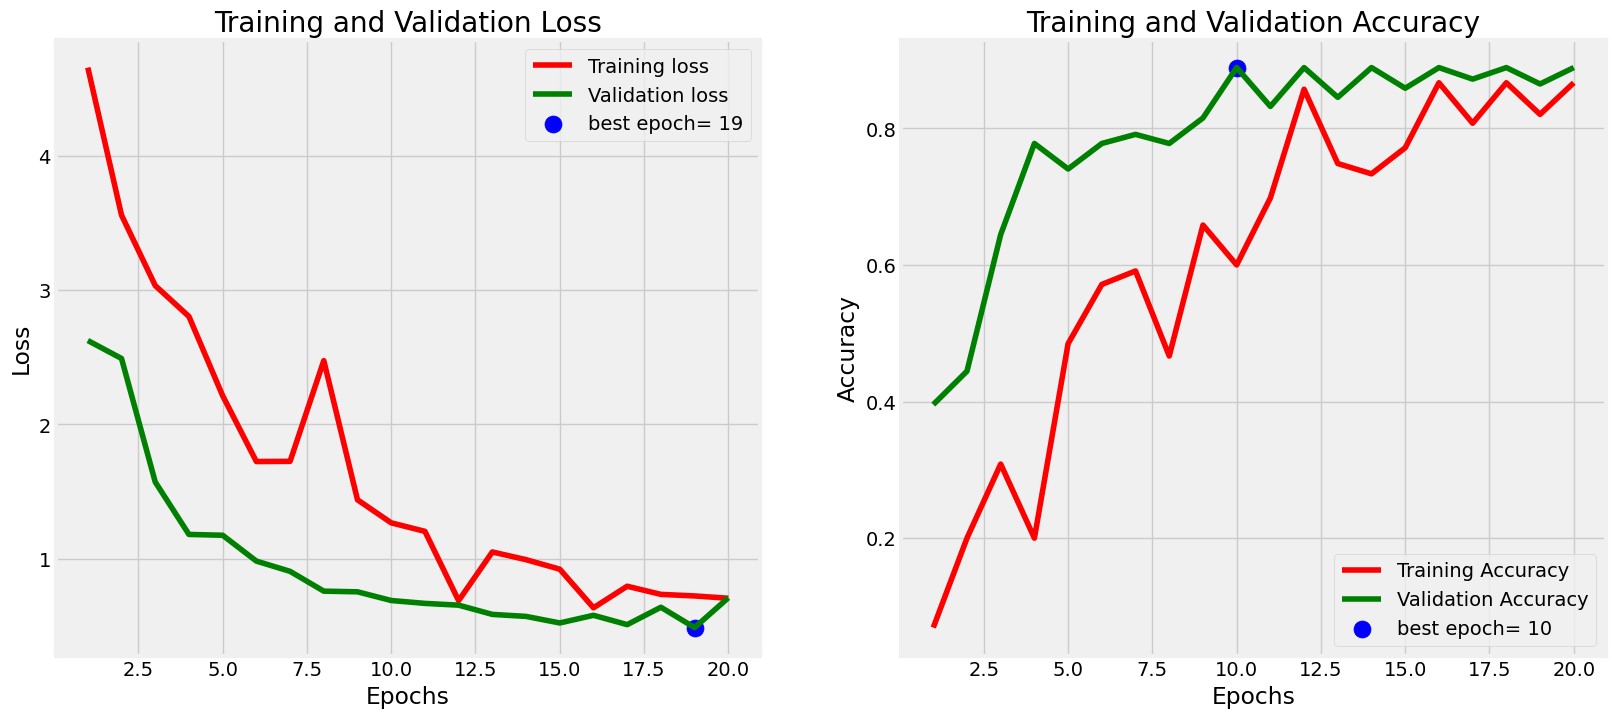

In [23]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(test_images, steps=test_images.samples // test_images.batch_size)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8863 - loss: 0.5136
Test accuracy: 0.8729
Test loss: 0.5044


Training : Fine Tuning!

In [26]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 80 layers
for l in pretrained_model.layers[:80]:
    l.name, l.trainable

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 90)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,201,161 (42.73 MB)

 Trainable params: 5,118,446 (19.53 MB)

 Non-trainable params: 6,082,715 (23.20 MB)

In [28]:
history = model.fit(
    train_images,
    steps_per_epoch=train_images.samples // train_images.batch_size,
    validation_data=val_images,
    validation_steps=val_images.samples // val_images.batch_size,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 25 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 65s 171ms/step - accuracy: 0.8869 - loss: 0.5300 - val_accuracy: 0.8827 - val_loss: 0.4233 - learning_rate: 1.0000e-05
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9333 - loss: 0.4837 - val_accuracy: 0.8889 - val_loss: 0.5587 - learning_rate: 1.0000e-05
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 150ms/step - accuracy: 0.8696 - loss: 0.5090 - val_accuracy: 0.8862 - val_loss: 0.4091 - learning_rate: 1.0000e-05
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.8667 - loss: 0.5526 - val_accuracy: 0.8889 - val_loss: 0.4737 - learning_rate: 1.0000e-05
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.8863 - loss: 0.4790 - val_accuracy: 0.8880 - val_loss: 0.4049 - learning_rate: 1.0000e-05
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9333 - loss: 0.3877 - val_accuracy: 0.8889 - val_loss: 0.4299 - learning_rate: 1.0000e-05
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/ste

Display model performance

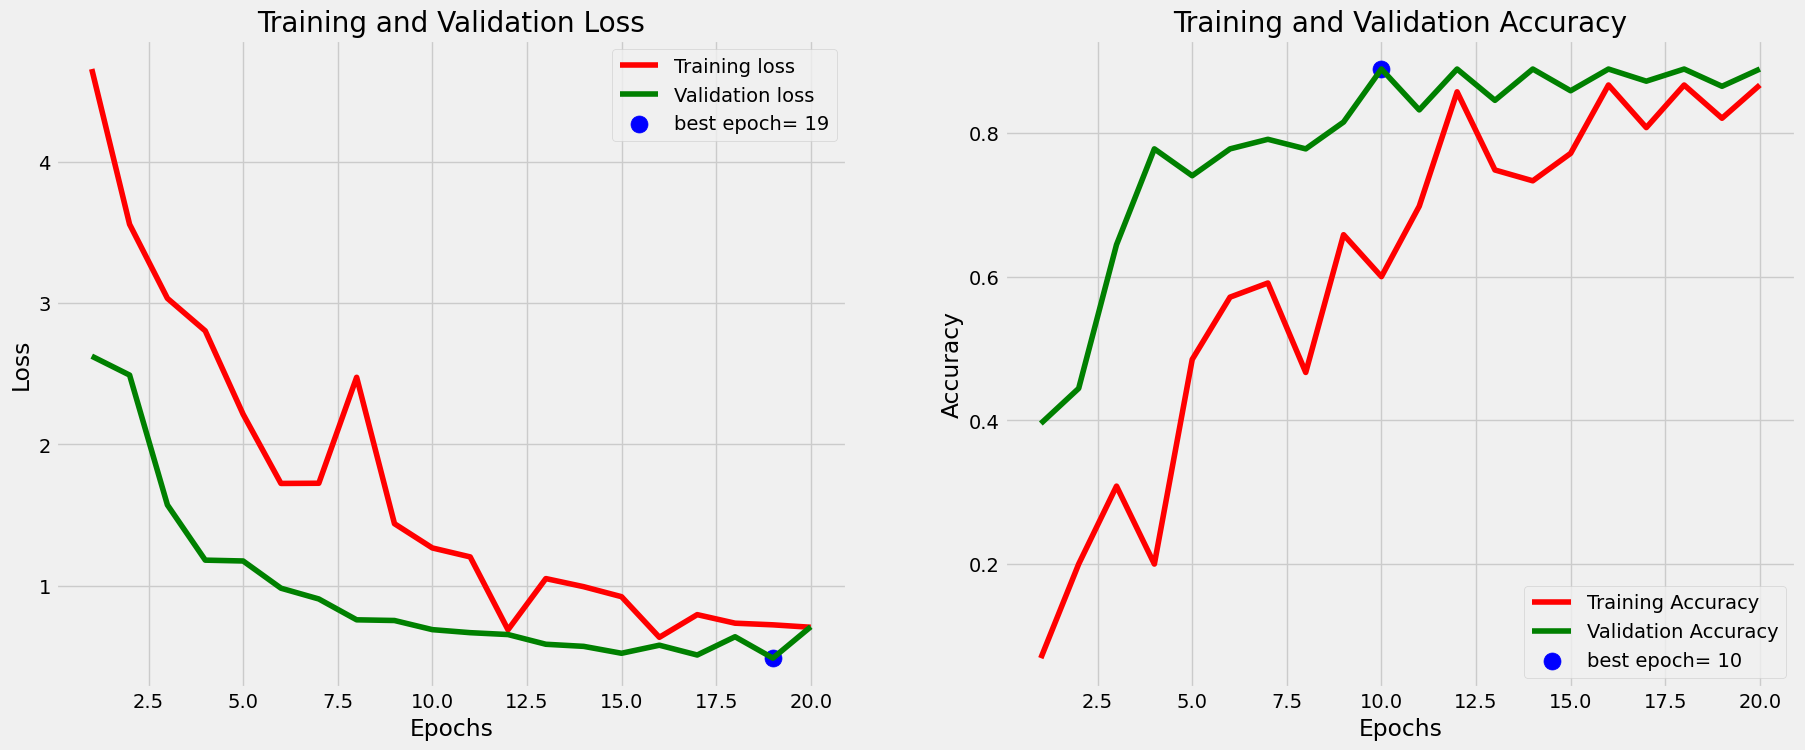

In [29]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [30]:
test_loss, test_accuracy = model.evaluate(test_images, steps=test_images.samples // test_images.batch_size)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9266 - loss: 0.3421
Test accuracy: 0.9042
Test loss: 0.3704


F1 Score / Recall / Precision

In [31]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step
F1 Score: 0.8965140667153052
                precision    recall  f1-score   support

      antelope       1.00      0.89      0.94         9
        badger       1.00      0.86      0.92         7
           bat       1.00      0.67      0.80         6
          bear       0.80      0.80      0.80         5
           bee       1.00      0.83      0.91         6
        beetle       1.00      1.00      1.00         7
         bison       1.00      0.75      0.86         4
          boar       0.33      1.00      0.50         1
     butterfly       0.57      1.00      0.73         4
           cat       1.00      0.83      0.91         6
   caterpillar       1.00      0.67      0.80         6
    chimpanzee       0.80      0.80      0.80         5
     cockroach       1.00      1.00      1.00         4
           cow       1.00      1.00      1.00         7
        coyote       1.00      0.88      0.93         8
          crab       1.00      1

**Get Predictions**

In [32]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           32  grasshopper                 32   
1            1           51        mouse                 35   
2            2           41    jellyfish                 41   
3            3           24     elephant                 24   
4            4            4          bee                  4   
5            5            0     antelope                  0   
6            6           18          dog                 18   
7            7           76        snake                 76   

  Prediction Classes                                               Path  \
0        grasshopper  /content/animals/animals/grasshopper/1fbdcee16...   
1           hedgehog      /content/animals/animals/mouse/719c8d79b6.jpg   
2          jellyfish  /content/animals/animals/jellyfish/7f9c6aed6f.jpg   
3           elephant   /content/animals/animals/elephant/31c31736c6.jpg   
4                bee        /content/animals/animals/bee/1111feb0ff.jpg   
5           antelope   /content/animals/animals/antelope/2c11ae88c0.jpg   
6                dog        /content/animals/animals/dog/7a47b70b45.jpg   
7              snake      /content/animals/animals/snake/0c6f39489a.jpg   

   Prediction Probability  
0                0.976310  
1                0.921835  
2                0.994373  
3                0.984544  
4                0.972150  
5                0.987017  
6                0.996811  
7                0.659531

Print the most confident errors

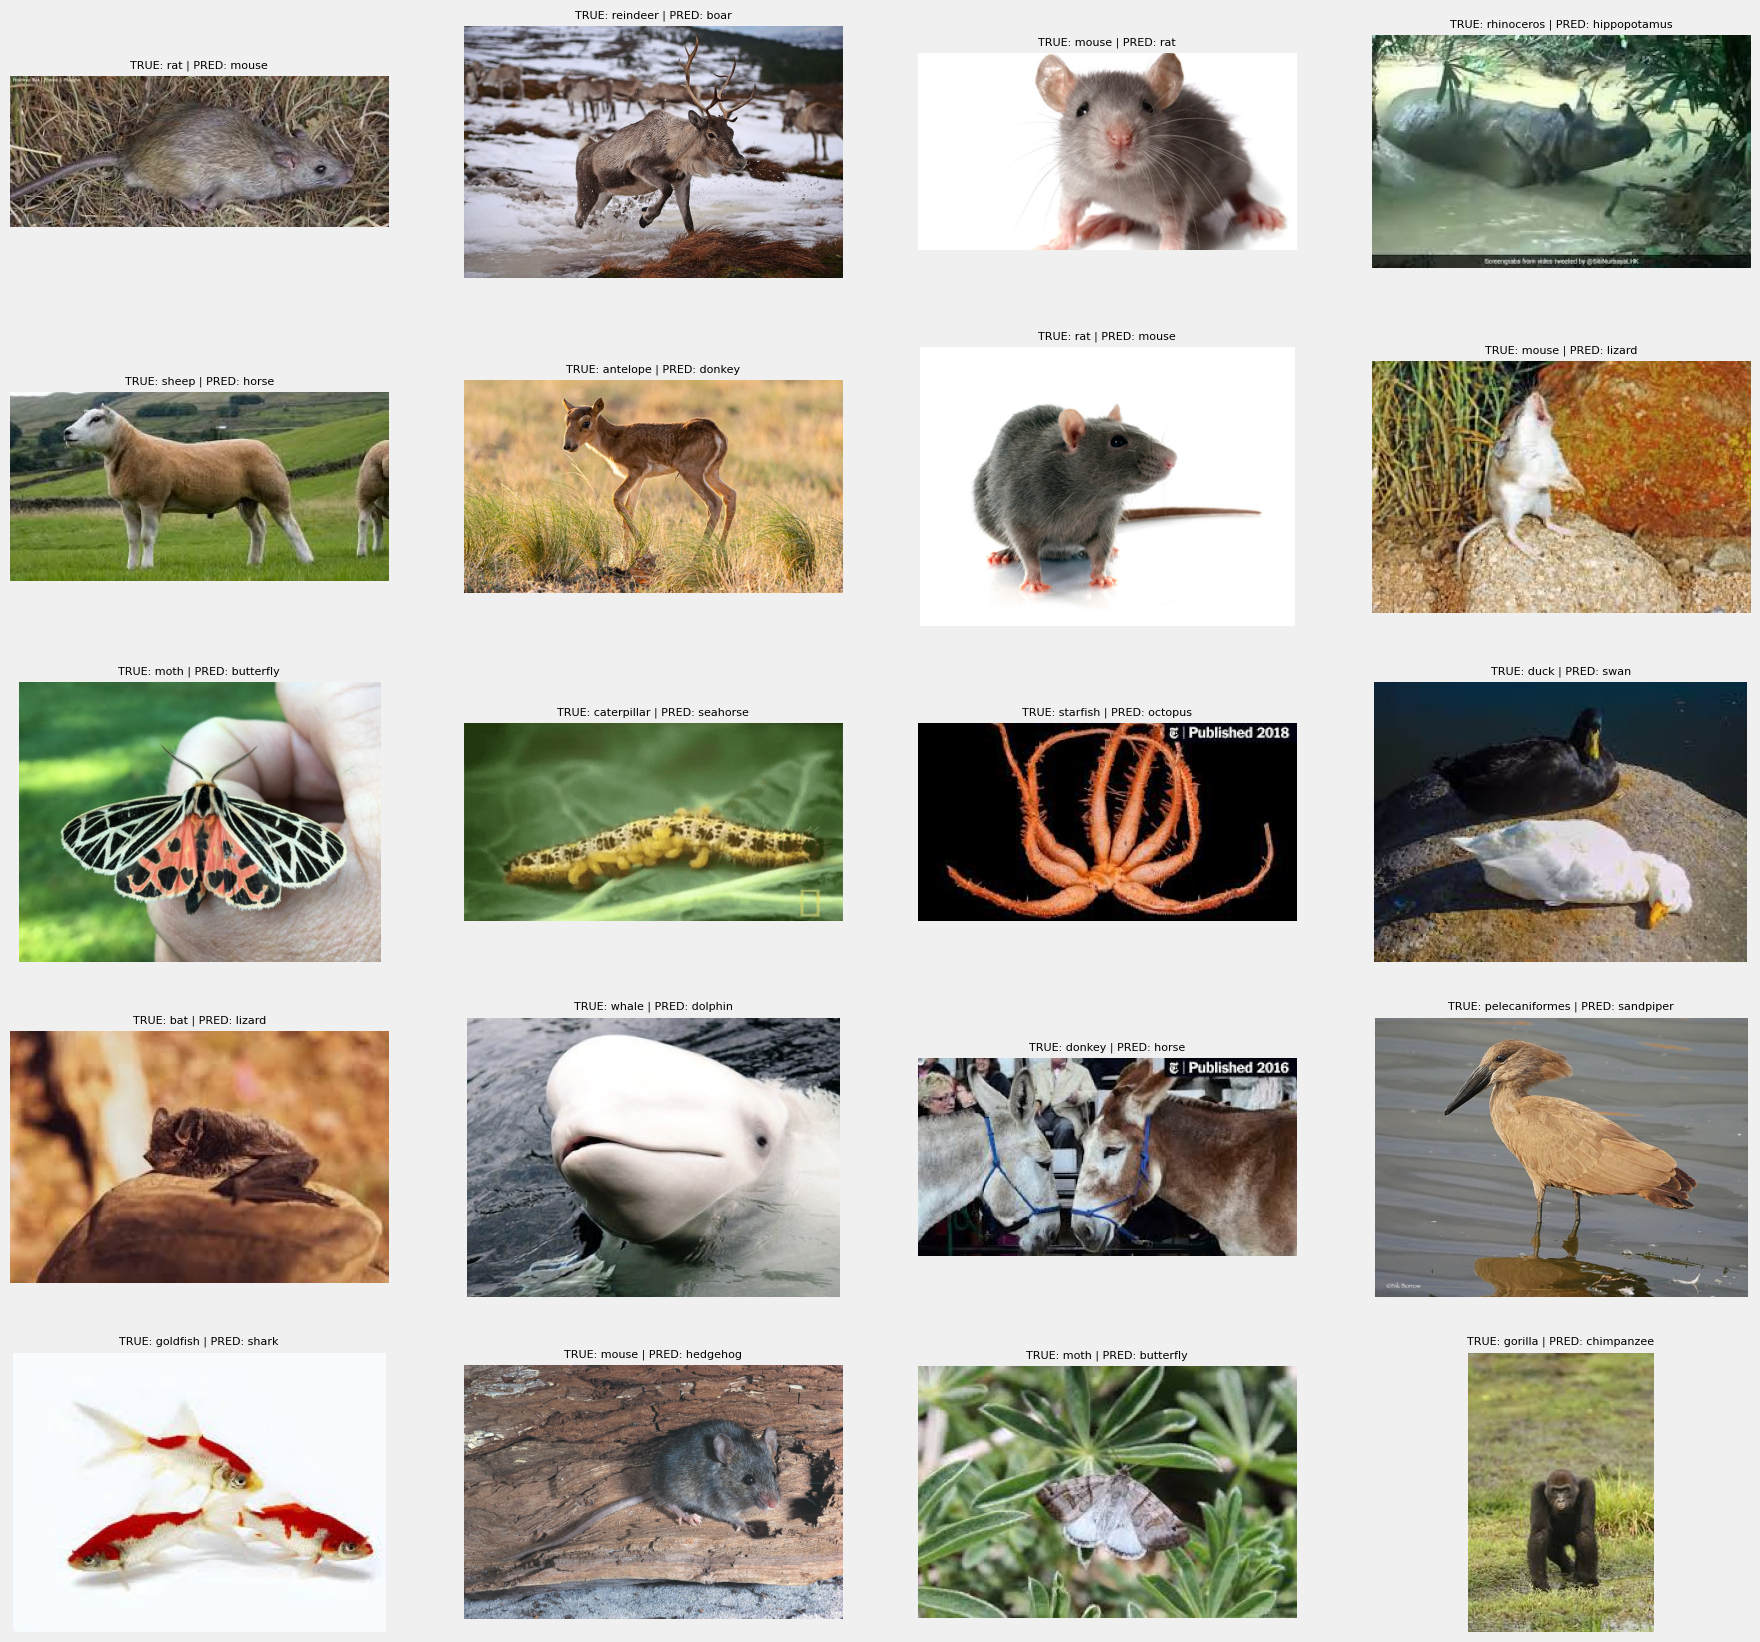

In [33]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Confusion Matrics and Classification Report

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step


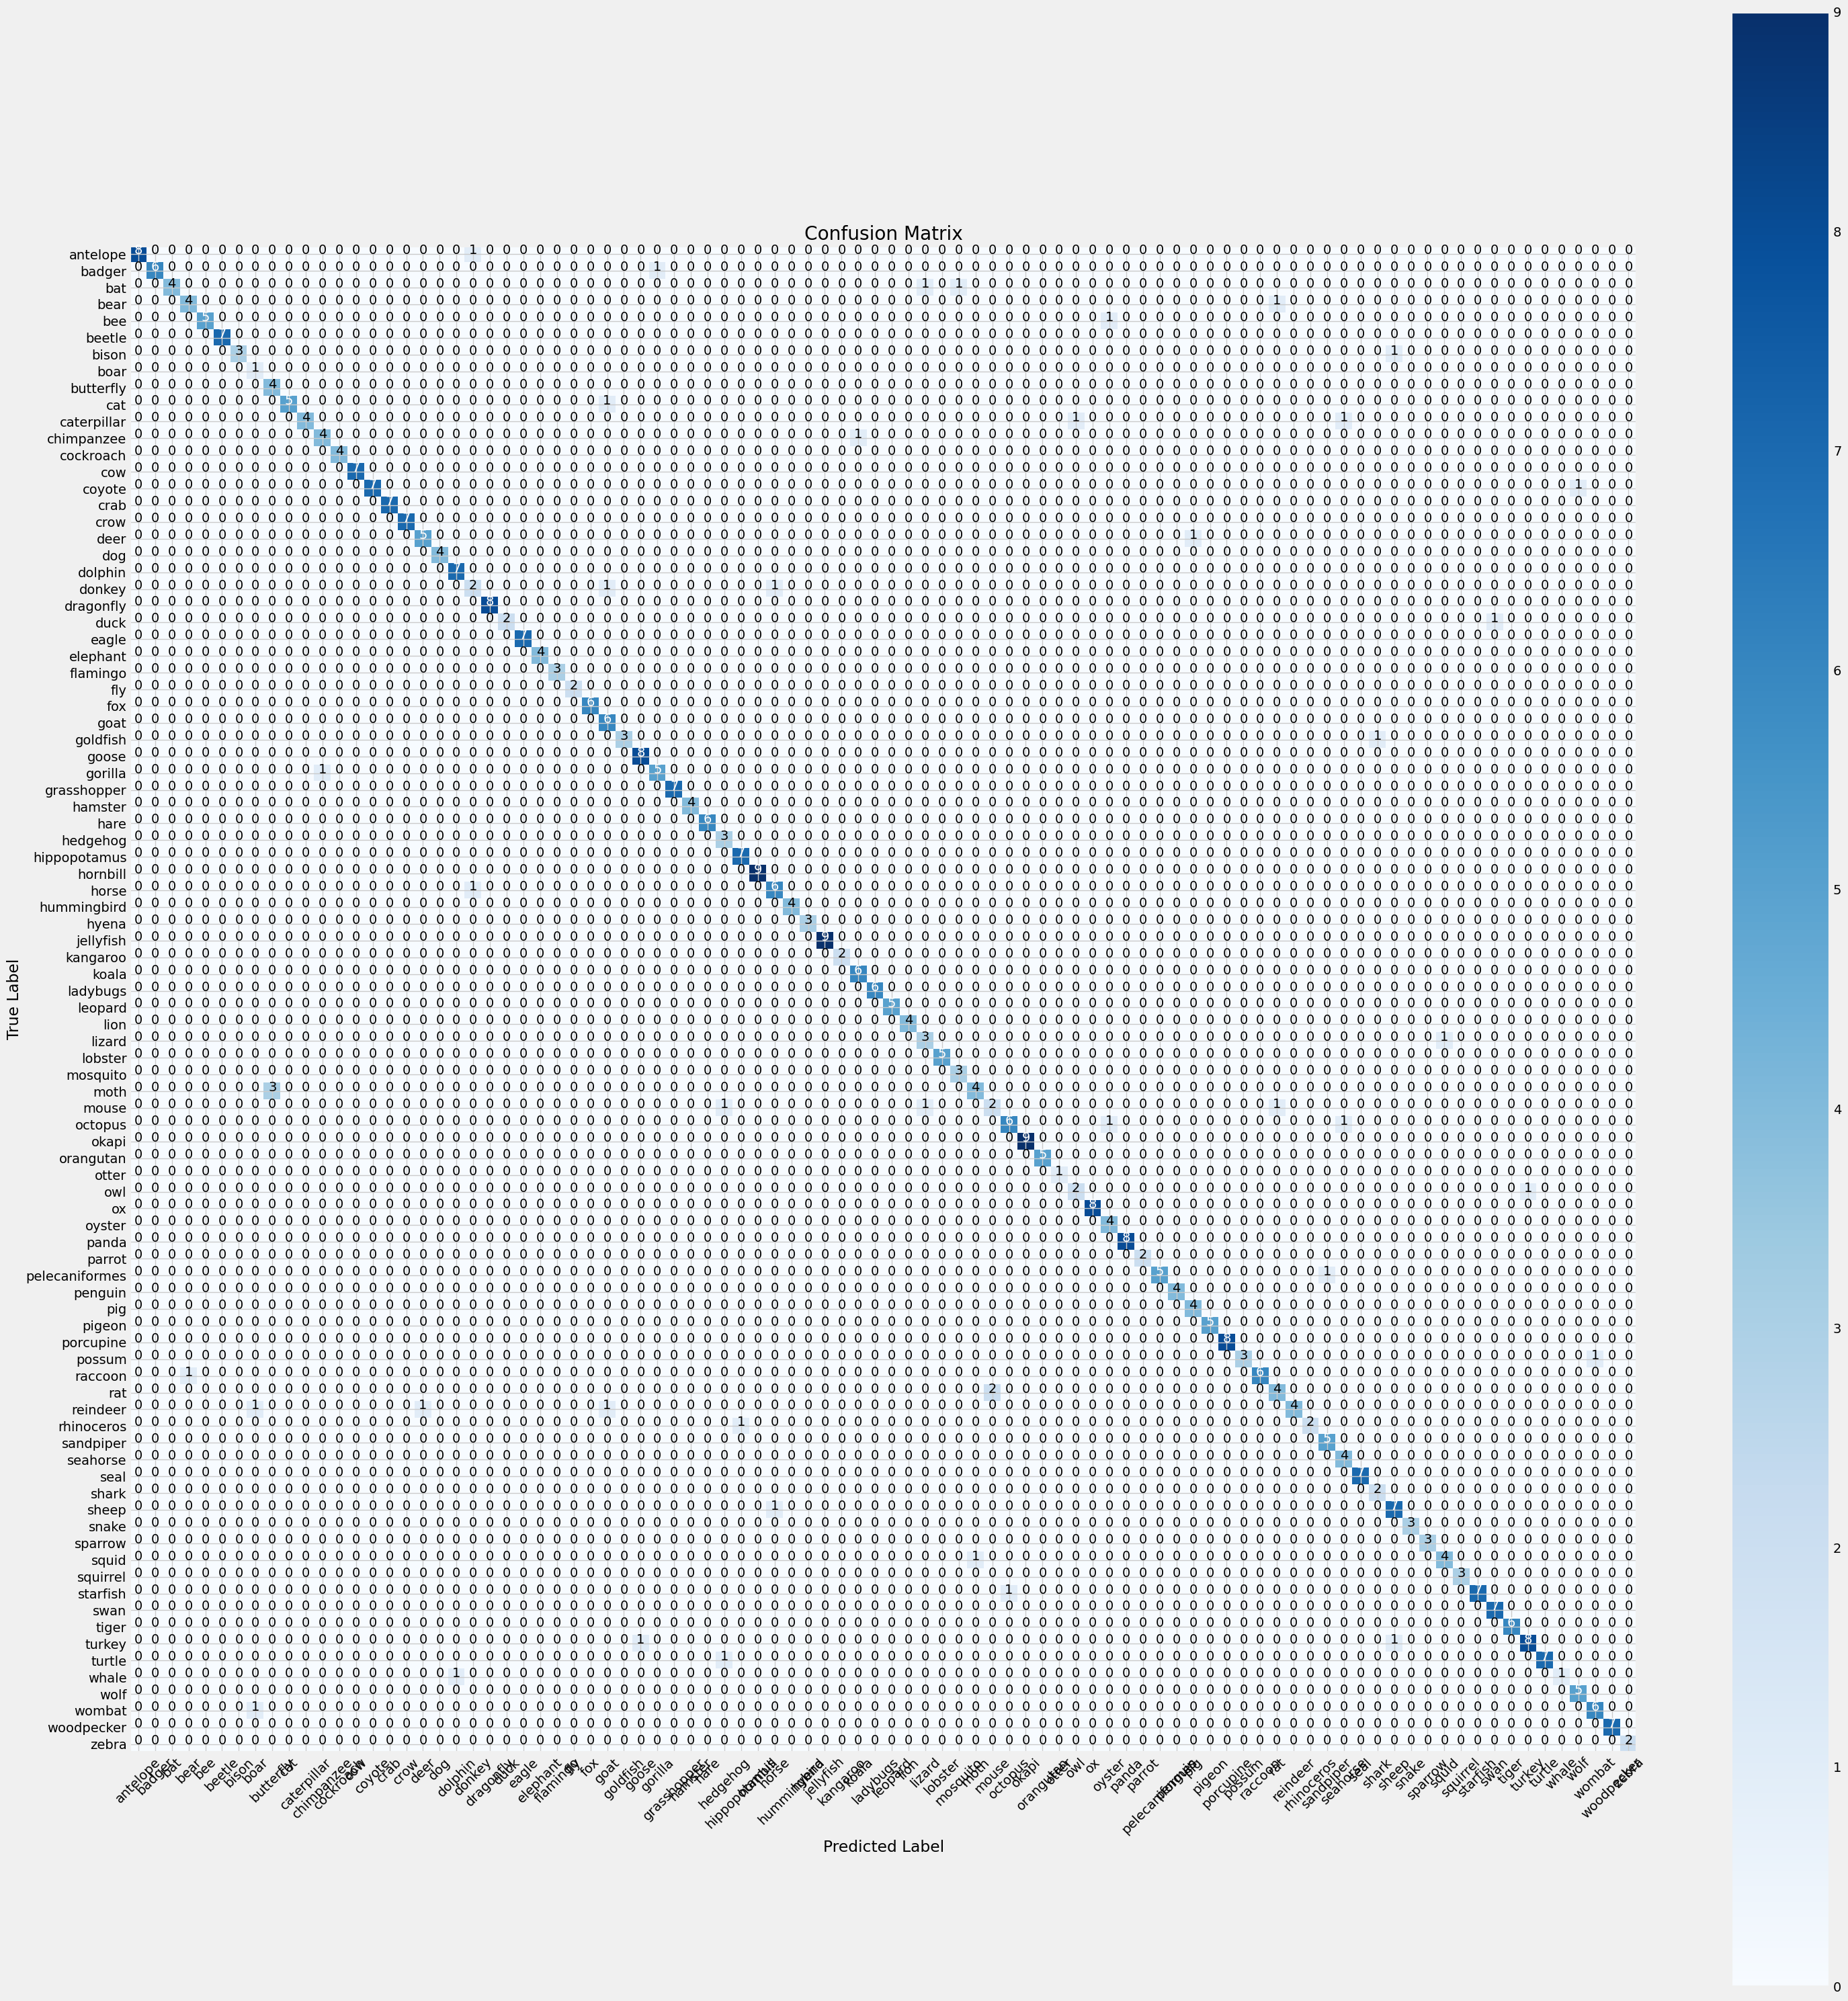

In [35]:
preds = model.predict(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

Save model:

In [55]:
model.save('/content/drive/MyDrive/Colab Notebooks/animal_classification_model.keras')

**Predicting...**

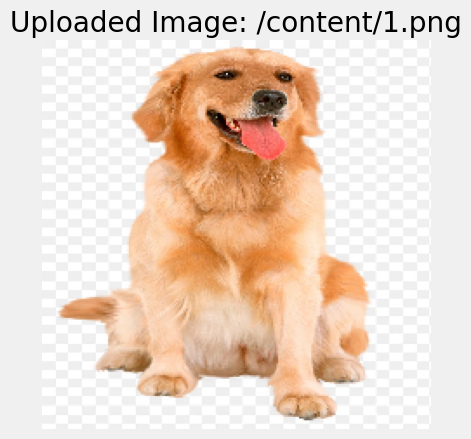

Image shape: (1, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


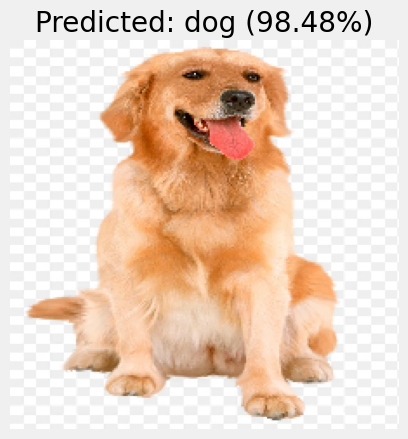

Predicted class index: 18
Predicted class name: dog
Class: antelope - Probability: 0.01%
Class: badger - Probability: 0.00%
Class: bat - Probability: 0.01%
Class: bear - Probability: 0.01%
Class: bee - Probability: 0.00%
Class: beetle - Probability: 0.01%
Class: bison - Probability: 0.01%
Class: boar - Probability: 0.01%
Class: butterfly - Probability: 0.03%
Class: cat - Probability: 0.03%
Class: caterpillar - Probability: 0.01%
Class: chimpanzee - Probability: 0.14%
Class: cockroach - Probability: 0.00%
Class: cow - Probability: 0.01%
Class: coyote - Probability: 0.01%
Class: crab - Probability: 0.00%
Class: crow - Probability: 0.02%
Class: deer - Probability: 0.00%
Class: dog - Probability: 98.48%
Class: dolphin - Probability: 0.00%
Class: donkey - Probability: 0.00%
Class: dragonfly - Probability: 0.00%
Class: duck - Probability: 0.17%
Class: eagle - Probability: 0.01%
Class: elephant - Probability: 0.01%
Class: flamingo - Probability: 0.01%
Class: fly - Probability: 0.01%
Class: fo

In [67]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/animal_classification_model.keras')

class_indices = {v: k for k, v in train_images.class_indices.items()}

# Predicting!
def predict_image_class(img_path):

    # Preprocesing...
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocessing...
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Drawing original image
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title(f'Uploaded Image: {img_path}')
    plt.axis('off')
    plt.show()
    print(f"Image shape: {img_array.shape}")

    # Predicting..
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Obtaining class by index
    predicted_class_name = class_indices[predicted_class]

    # Drawing result
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title(f'Predicted: {predicted_class_name} ({np.max(predictions[0])*100:.2f}%)')
    plt.axis('off')
    plt.show()

    print(f"Predicted class index: {predicted_class}")
    print(f"Predicted class name: {predicted_class_name}")

    # Probabilities for all classes
    for i, prob in enumerate(predictions[0]):
        print(f"Class: {class_indices[i]} - Probability: {prob*100:.2f}%")

uploaded_image_path = '/content/1.png'
predict_image_class(uploaded_image_path)
